# Setup

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import f_classif
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, classification_report, f1_score

from catboost.metrics import BuiltinMetric
from catboost import CatBoostClassifier, CatBoostRegressor

import warnings
warnings.filterwarnings("ignore")

# Prepare the data

In [30]:
df = pd.read_csv('../dataset/survey.csv')
df.head()

,Timestamp,Age,Gender,Country,state,self_employed,family_history,treatment,work_interfere,no_employees,...,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,comments
0,2014-08-27 11:29:31,37,Female,United States,IL,NaN,No,Yes,Often,6-25,...,Somewhat easy,No,No,Some of them,Yes,No,Maybe,Yes,No,NaN
1,2014-08-27 11:29:37,44,M,United States,IN,NaN,No,No,Rarely,More than 1000,...,Don't know,Maybe,No,No,No,No,No,Don't know,No,NaN
2,2014-08-27 11:29:44,32,Male,Canada,NaN,NaN,No,No,Rarely,6-25,...,Somewhat difficult,No,No,Yes,Yes,Yes,Yes,No,No,NaN
3,2014-08-27 11:29:46,31,Male,United Kingdom,NaN,NaN,Yes,Yes,Often,26-100,...,Somewhat difficult,Yes,Yes,Some of them,No,Maybe,Maybe,No,Yes,NaN
4,2014-08-27 11:30:22,31,Male,United States,TX,NaN,No,No,Never,100-500,...,Don't know,No,No,Some of them,Yes,Yes,Yes,Don't know,No,NaN


In [3]:
# Plot nilai nunique dari setiap kolom
fig = px.bar(x=df.columns, y=df.nunique(), title='Jumlah nilai unik dari setiap kolom')
fig.show()

## Preprocess missing values

In [4]:
# Plot missing values
missing = df.isnull().sum()
missing = missing[missing > 0]
missing = missing.sort_values()

fig = px.bar(missing, x=missing.index, y=missing.values, title='Missing Values')
fig.show()

In [5]:
# Encode kolom self_employed, dan work_interfere
df['self_employed'] = df['self_employed'].replace({'Yes': 1, 'No': 0})
df['work_interfere'] = df['work_interfere'].replace({'Never': 0, 'Rarely': 1, 'Sometimes': 2, 'Often': 3})

In [6]:
# KNN Imputer kolom self_employed, work_interfere
imputer = KNNImputer(n_neighbors=3)
df[['self_employed', 'work_interfere']] = imputer.fit_transform(df[['self_employed', 'work_interfere']])
df.head()

,Timestamp,Age,Gender,Country,state,self_employed,family_history,treatment,work_interfere,no_employees,...,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,comments
0,2014-08-27 11:29:31,37,Female,United States,IL,0.000000,No,Yes,3.0,6-25,...,Somewhat easy,No,No,Some of them,Yes,No,Maybe,Yes,No,NaN
1,2014-08-27 11:29:37,44,M,United States,IN,0.333333,No,No,1.0,More than 1000,...,Don't know,Maybe,No,No,No,No,No,Don't know,No,NaN
2,2014-08-27 11:29:44,32,Male,Canada,NaN,0.333333,No,No,1.0,6-25,...,Somewhat difficult,No,No,Yes,Yes,Yes,Yes,No,No,NaN
3,2014-08-27 11:29:46,31,Male,United Kingdom,NaN,0.000000,Yes,Yes,3.0,26-100,...,Somewhat difficult,Yes,Yes,Some of them,No,Maybe,Maybe,No,Yes,NaN
4,2014-08-27 11:30:22,31,Male,United States,TX,0.333333,No,No,0.0,100-500,...,Don't know,No,No,Some of them,Yes,Yes,Yes,Don't know,No,NaN


In [7]:
# pembulatan angka pada kolom work_interfere dan self_employed
df['work_interfere'] = df['work_interfere'].round().astype(int)
df['self_employed'] = df['self_employed'].round().astype(int)

In [8]:
# Konversikan kembali kolom work_interfere dan self_employed menjadi object
df['work_interfere'] = df['work_interfere'].replace({0: 'Never', 1: 'Rarely', 2: 'Sometimes', 3: 'Often'})
df['self_employed'] = df['self_employed'].replace({0: 'No', 1: 'Yes'})

## Preprocess gender columns

In [9]:
df['Gender'].value_counts()

Gender
Male                                              615
male                                              206
Female                                            121
M                                                 116
female                                             62
F                                                  38
m                                                  34
f                                                  15
Make                                                4
Male                                                3
Woman                                               3
Cis Male                                            2
Man                                                 2
Female (trans)                                      2
Female                                              2
Trans woman                                         1
msle                                                1
male leaning androgynous                            1
Neuter               

In [10]:
# Drop beberapa kolom
df = df.drop(columns=['state', 'comments', 'Gender', 'Timestamp', 'Country', 'Age', 'self_employed', 'no_employees', 'remote_work', 'tech_company'])
df.head()

,family_history,treatment,work_interfere,benefits,care_options,wellness_program,seek_help,anonymity,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence
0,No,Yes,Often,Yes,Not sure,No,Yes,Yes,Somewhat easy,No,No,Some of them,Yes,No,Maybe,Yes,No
1,No,No,Rarely,Don't know,No,Don't know,Don't know,Don't know,Don't know,Maybe,No,No,No,No,No,Don't know,No
2,No,No,Rarely,No,No,No,No,Don't know,Somewhat difficult,No,No,Yes,Yes,Yes,Yes,No,No
3,Yes,Yes,Often,No,Yes,No,No,No,Somewhat difficult,Yes,Yes,Some of them,No,Maybe,Maybe,No,Yes
4,No,No,Never,Yes,No,Don't know,Don't know,Don't know,Don't know,No,No,Some of them,Yes,Yes,Yes,Don't know,No


In [11]:
# Menampilkan nilai yang uniq di semua kolom
for column in df.columns:
    print(f"{column} : {df[column].unique()}")

family_history : ['No' 'Yes']
treatment : ['Yes' 'No']
work_interfere : ['Often' 'Rarely' 'Never' 'Sometimes']
benefits : ['Yes' "Don't know" 'No']
care_options : ['Not sure' 'No' 'Yes']
wellness_program : ['No' "Don't know" 'Yes']
seek_help : ['Yes' "Don't know" 'No']
anonymity : ['Yes' "Don't know" 'No']
leave : ['Somewhat easy' "Don't know" 'Somewhat difficult' 'Very difficult'
 'Very easy']
mental_health_consequence : ['No' 'Maybe' 'Yes']
phys_health_consequence : ['No' 'Yes' 'Maybe']
coworkers : ['Some of them' 'No' 'Yes']
supervisor : ['Yes' 'No' 'Some of them']
mental_health_interview : ['No' 'Yes' 'Maybe']
phys_health_interview : ['Maybe' 'No' 'Yes']
mental_vs_physical : ['Yes' "Don't know" 'No']
obs_consequence : ['No' 'Yes']


## Summary the columns

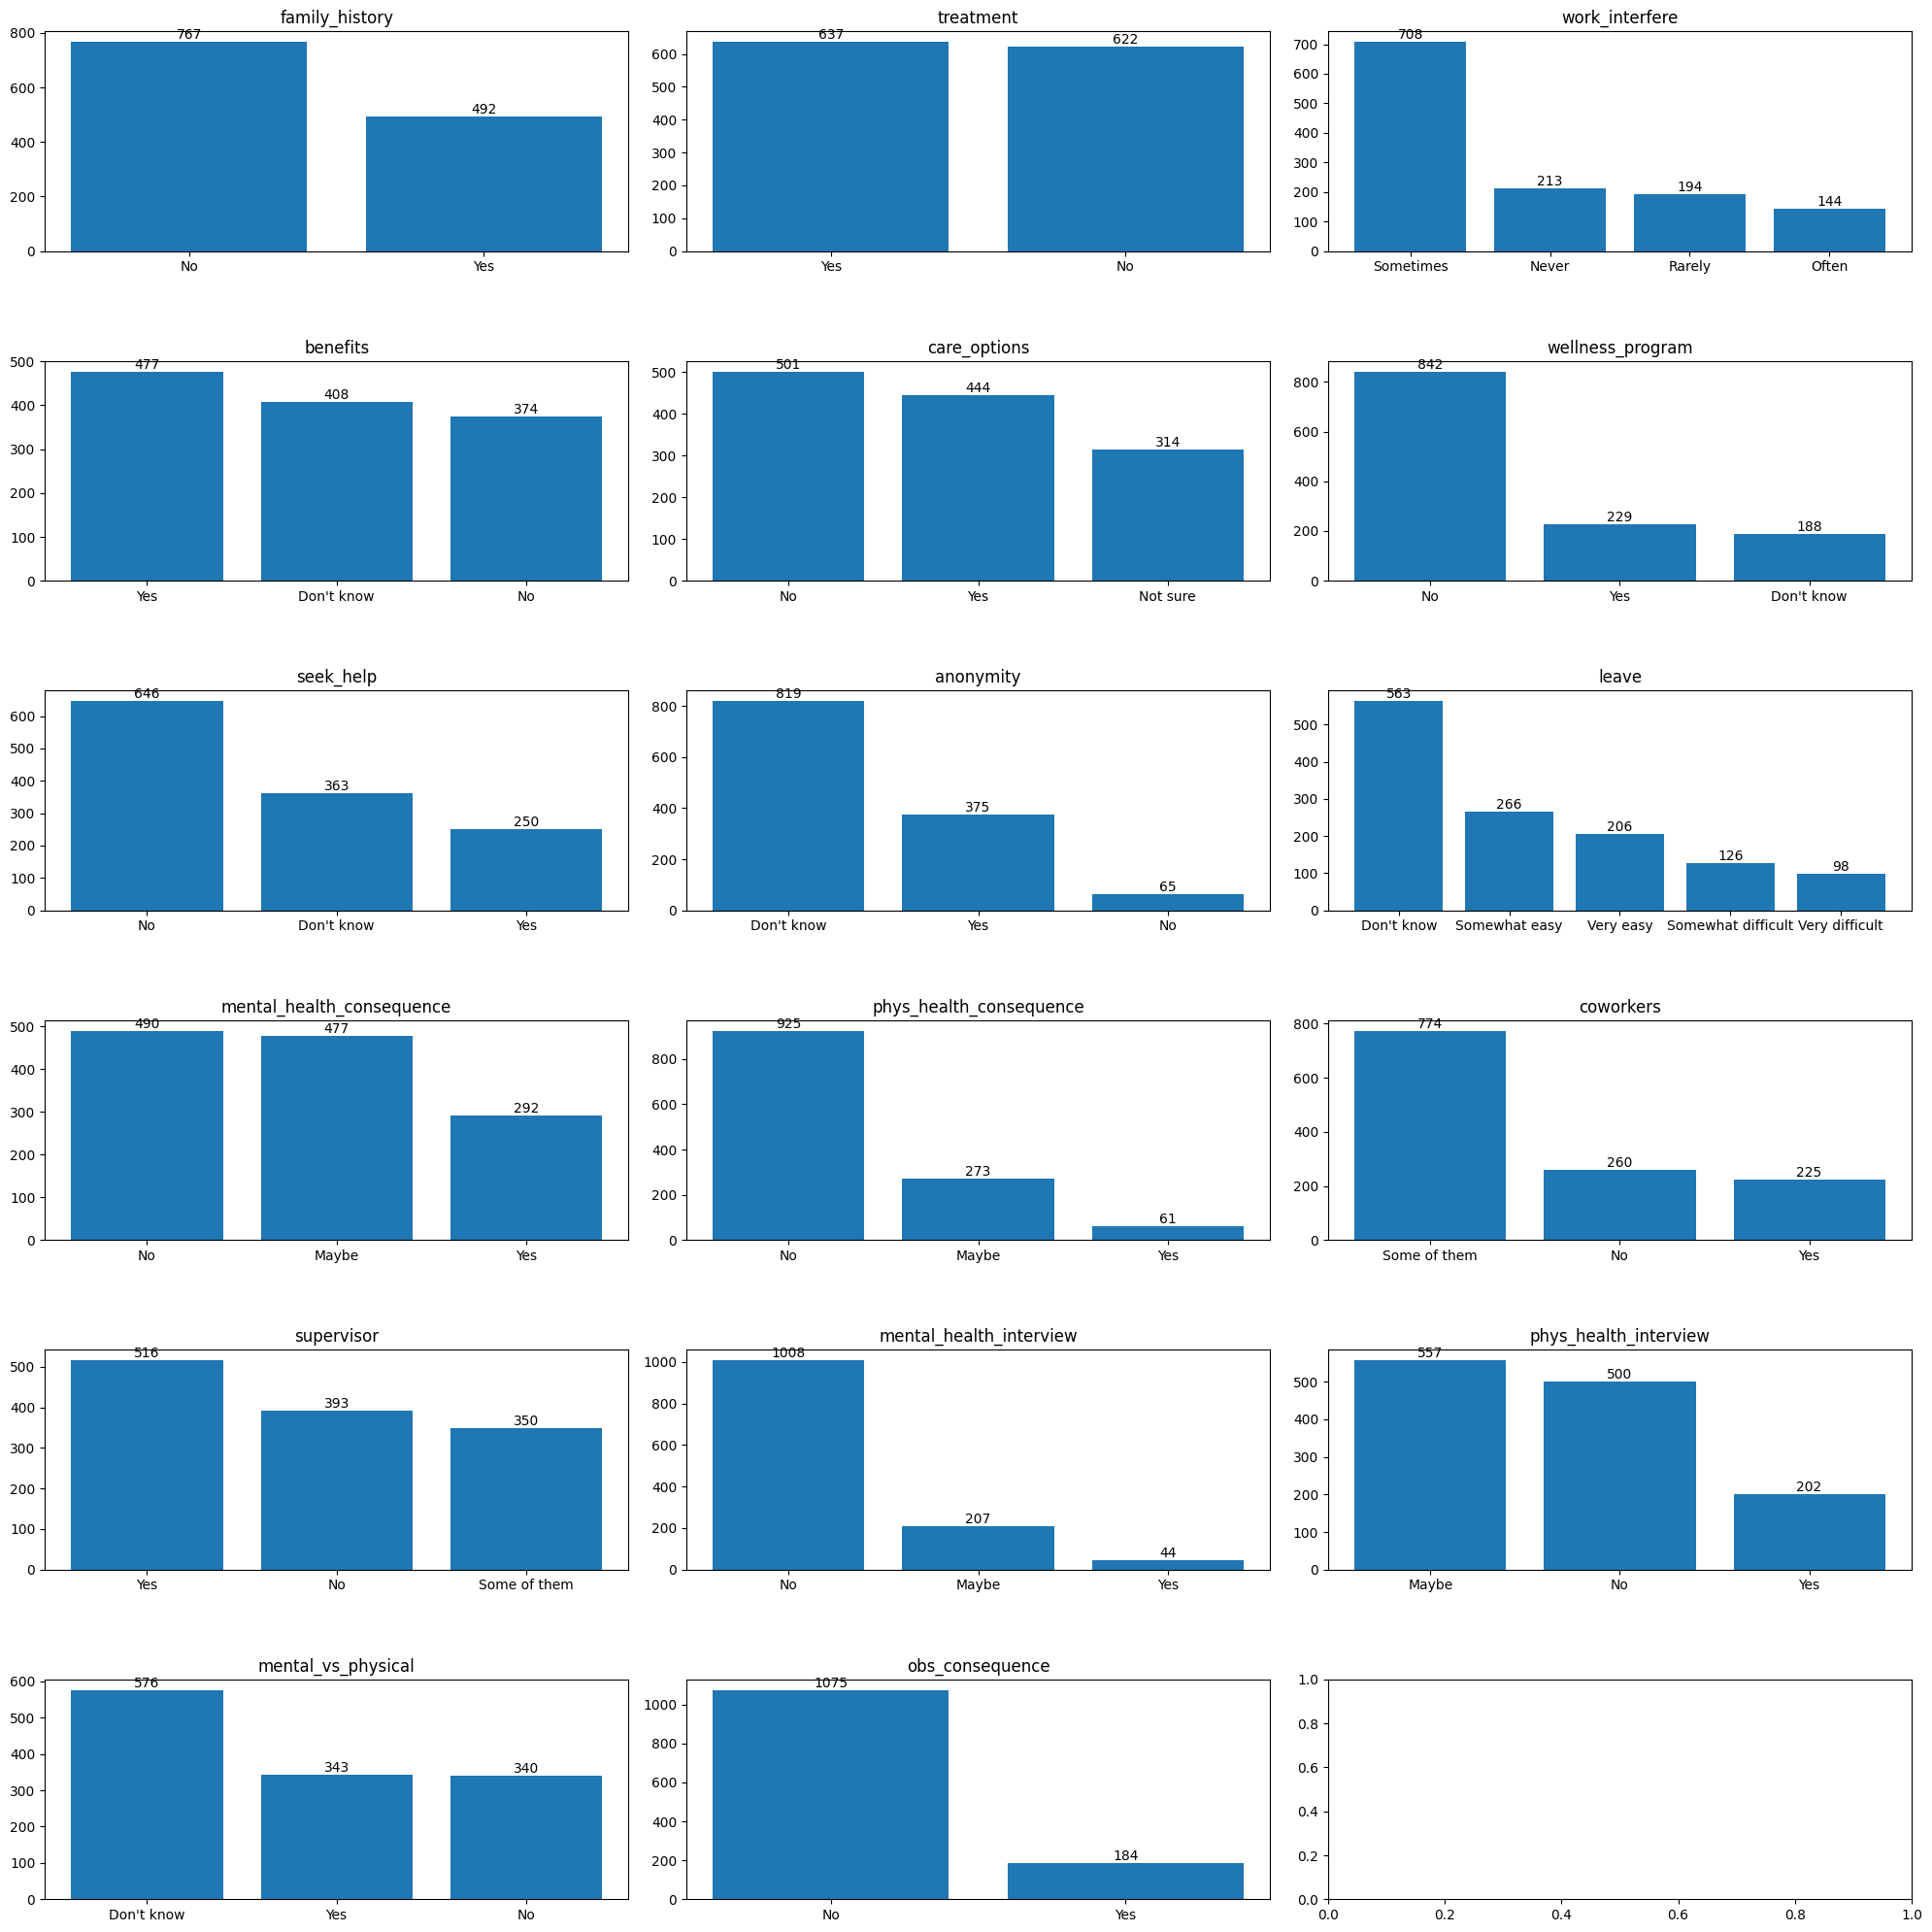

In [12]:
# Membuat plot value count dari setiap kolom menggunakan pyplot
fig, axes = plt.subplots(nrows=6, ncols=3, figsize=(20, 20))

for i, column in enumerate(df.columns):
    index = df[column].value_counts().index
    values = df[column].value_counts().values
    ax = axes[i//3, i%3]
    ax.bar(index, values)
    for i, v in enumerate(values):
        ax.text(i, v, str(v), ha='center', va='bottom')
    ax.set_title(column)
    ax.set_xticklabels(index)
    
plt.tight_layout()
plt.subplots_adjust(hspace=0.5)

In [13]:
# to_csv
df.to_csv('../dataset/cleaned_survey.csv', index=False)

In [62]:
df = pd.read_csv('../dataset/cleaned_survey.csv')
df.head()

,family_history,treatment,work_interfere,benefits,care_options,wellness_program,seek_help,anonymity,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence
0,No,Yes,Often,Yes,Not sure,No,Yes,Yes,Somewhat easy,No,No,Some of them,Yes,No,Maybe,Yes,No
1,No,No,Rarely,Don't know,No,Don't know,Don't know,Don't know,Don't know,Maybe,No,No,No,No,No,Don't know,No
2,No,No,Rarely,No,No,No,No,Don't know,Somewhat difficult,No,No,Yes,Yes,Yes,Yes,No,No
3,Yes,Yes,Often,No,Yes,No,No,No,Somewhat difficult,Yes,Yes,Some of them,No,Maybe,Maybe,No,Yes
4,No,No,Never,Yes,No,Don't know,Don't know,Don't know,Don't know,No,No,Some of them,Yes,Yes,Yes,Don't know,No


## Label encoder

In [63]:
def label_encoder(df):
    encode1 = {
        'No': 0,
        'Yes': 1
    }

    encode2 = {
        'Never': 0,
        'Rarely': 1,
        'Sometimes': 2,
        'Often': 3
    }

    encode3 = {
        'No': 0,
        'Not sure': 1,
        'Yes': 2
    }

    encode4 = {
        'Very difficult': 0,
        'Somewhat difficult': 1,
        "Don't know": 2,
        'Somewhat easy': 3,
        'Very easy': 4
    }

    encode5 = {
        'No': 0,
        'Maybe': 1,
        'Yes': 2
    }

    encode6 = {
        'No': 0,
        'Some of them': 1,
        'Yes': 2
    }

    encode7 = {
        'No': 0,
        "Don't know": 1,
        'Yes': 2
    }

    # Encode semua kolom berdasarkan mapping diatas
    for column in df.columns:
        if df[column].dtype == 'object':
            unique_values = df[column].unique().tolist()
            if set(unique_values) == set(['No', 'Yes']):
                df[column] = df[column].map(encode1)
            elif set(unique_values) == set(['Never', 'Rarely', 'Sometimes', 'Often']):
                df[column] = df[column].map(encode2)
            elif set(unique_values) == set(['No', 'Not sure', 'Yes']):
                df[column] = df[column].map(encode3)
            elif set(unique_values) == set(['Very difficult', 'Somewhat difficult', "Don't know", 'Somewhat easy', 'Very easy']):
                df[column] = df[column].map(encode4)
            elif set(unique_values) == set(['No', 'Maybe', 'Yes']):
                df[column] = df[column].map(encode5)
            elif set(unique_values) == set(['No', 'Some of them', 'Yes']):
                df[column] = df[column].map(encode6)
            elif set(unique_values) == set(['No', "Don't know", 'Yes']):
                df[column] = df[column].map(encode7)

    return df

df = label_encoder(df)
df.head()

,family_history,treatment,work_interfere,benefits,care_options,wellness_program,seek_help,anonymity,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence
0,0,1,3,2,1,0,2,2,3,0,0,1,2,0,1,2,0
1,0,0,1,1,0,1,1,1,2,1,0,0,0,0,0,1,0
2,0,0,1,0,0,0,0,1,1,0,0,2,2,2,2,0,0
3,1,1,3,0,2,0,0,0,1,2,2,1,0,1,1,0,1
4,0,0,0,2,0,1,1,1,2,0,0,1,2,2,2,1,0


## Feature selection

In [16]:
# Plot korelasi antar kolom dengan kolom treatment
corr_df = df.copy()

df_dummies = pd.DataFrame({
    'Feature': corr_df.drop(columns=['treatment']).columns,
    'Correlation': corr_df.drop(columns=['treatment']).corrwith(corr_df['treatment']).values
}).sort_values(by='Correlation', ascending=False)

bar = px.bar(df_dummies, x='Feature', y='Correlation', title='Korelasi antar kolom dengan kolom treatment')
bar.show()

# Generate the model

In [17]:
# Split data menjadi data train dan data test
X = df.drop(columns=['treatment'])
y = df['treatment']

## Tuning seed

In [18]:
accuracy = []

for i in range(400):
    print(f"Training model ke-{i+1}")
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=i)

    cat = CatBoostClassifier(
        iterations=100,
        learning_rate=0.1,
        depth=10,
        loss_function='Logloss',
        verbose=5,
        eval_metric='Accuracy',
        use_best_model=True,
        random_seed=i
    )

    cat.fit(
        X_train, 
        y_train, 
        eval_set=(X_test, y_test), 
        verbose=100
    )
    
    y_pred = cat.predict(X_test)
    accuracy.append(accuracy_score(y_test, y_pred))
    
    print("")

In [19]:
# mengambil index dari model dengan akurasi tertinggi
best_model_index = accuracy.index(max(accuracy))
best_model_index

## Train the model

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=104)

cat = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.1,
    depth=10, 
    loss_function='Logloss',
    verbose=5,
    eval_metric='Accuracy',
    use_best_model=True,
    random_seed=104
)

cat.fit(
    X_train, 
    y_train, 
    eval_set=(X_test, y_test), 
    verbose=100
)

0:	learn: 0.7934459	test: 0.7380952	best: 0.7380952 (0)	total: 165ms	remaining: 2m 45s
100:	learn: 0.9890765	test: 0.7539683	best: 0.8174603 (17)	total: 532ms	remaining: 4.73s
200:	learn: 0.9930487	test: 0.7261905	best: 0.8174603 (17)	total: 901ms	remaining: 3.58s
300:	learn: 0.9930487	test: 0.7301587	best: 0.8174603 (17)	total: 1.27s	remaining: 2.96s
400:	learn: 0.9930487	test: 0.7182540	best: 0.8174603 (17)	total: 1.64s	remaining: 2.45s
500:	learn: 0.9930487	test: 0.7222222	best: 0.8174603 (17)	total: 2.02s	remaining: 2.01s
600:	learn: 0.9930487	test: 0.7142857	best: 0.8174603 (17)	total: 2.4s	remaining: 1.59s
700:	learn: 0.9930487	test: 0.7142857	best: 0.8174603 (17)	total: 2.77s	remaining: 1.18s
800:	learn: 0.9930487	test: 0.7142857	best: 0.8174603 (17)	total: 3.14s	remaining: 780ms
900:	learn: 0.9930487	test: 0.7142857	best: 0.8174603 (17)	total: 3.52s	remaining: 387ms
999:	learn: 0.9930487	test: 0.7142857	best: 0.8174603 (17)	total: 3.91s	remaining: 0us

bestTest = 0.8174603175
b

## Metrics evaluation

In [19]:
y_pred = cat.predict(X_test)
print(f"Accuracy : {accuracy_score(y_test, y_pred)}")

Accuracy : 0.8174603174603174


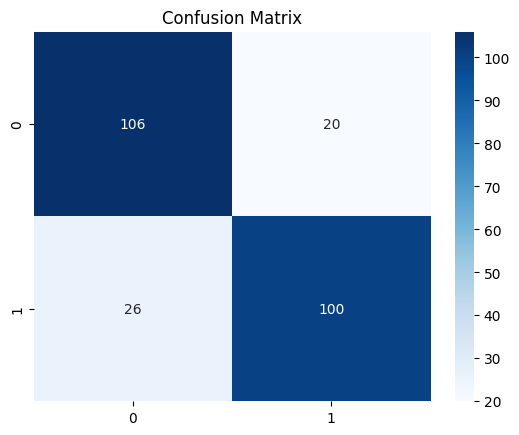

In [20]:
# confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm = pd.DataFrame(cm, index=cat.classes_, columns=cat.classes_)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

In [21]:
y_pred = cat.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.84      0.82       126
           1       0.83      0.79      0.81       126

    accuracy                           0.82       252
   macro avg       0.82      0.82      0.82       252
weighted avg       0.82      0.82      0.82       252



In [22]:
# save model
cat.save_model('../saved model/catboost_model')

# Testing

In [24]:
# load model
cat = CatBoostClassifier()
cat.load_model('../saved model/catboost_model')

In [25]:
data = {
    # 'self_employed': ['No'],
    # 'no_employees': ['1-5'],
    # 'remote_work': ['No'],
    # 'tech_company': ['Yes'],
    'family_history': ['No'],
    'work_interfere': ['Never'],
    'benefits': ['Yes'],
    'care_options': ['Yes'],
    'wellness_program': ['Yes'],
    'seek_help': ['Yes'],
    'anonymity': ['Yes'],
    'leave': ['Very easy'],
    'mental_health_consequence': ['No'],
    'phys_health_consequence': ['No'],
    'coworkers': ['Some of them'],
    'supervisor': ['Yes'],
    'mental_health_interview': ['No'],
    'phys_health_interview': ['No'],
    'mental_vs_physical': ['Yes'],
    'obs_consequence': ['No']
}

data = pd.DataFrame(data)
data.head()

,family_history,work_interfere,benefits,care_options,wellness_program,seek_help,anonymity,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence
0,No,Never,Yes,Yes,Yes,Yes,Yes,Very easy,No,No,Some of them,Yes,No,No,Yes,No


In [26]:
df = pd.read_csv('../dataset/cleaned_survey.csv')   

# print unique values
for column in df.columns:
    print(f"{column} : {df[column].unique()}")

family_history : ['No' 'Yes']
treatment : ['Yes' 'No']
work_interfere : ['Often' 'Rarely' 'Never' 'Sometimes']
benefits : ['Yes' "Don't know" 'No']
care_options : ['Not sure' 'No' 'Yes']
wellness_program : ['No' "Don't know" 'Yes']
seek_help : ['Yes' "Don't know" 'No']
anonymity : ['Yes' "Don't know" 'No']
leave : ['Somewhat easy' "Don't know" 'Somewhat difficult' 'Very difficult'
 'Very easy']
mental_health_consequence : ['No' 'Maybe' 'Yes']
phys_health_consequence : ['No' 'Yes' 'Maybe']
coworkers : ['Some of them' 'No' 'Yes']
supervisor : ['Yes' 'No' 'Some of them']
mental_health_interview : ['No' 'Yes' 'Maybe']
phys_health_interview : ['Maybe' 'No' 'Yes']
mental_vs_physical : ['Yes' "Don't know" 'No']
obs_consequence : ['No' 'Yes']


In [27]:
encode1 = {
    'No': 0,
    'Yes': 1
}

encode2 = {
    'Never': 0,
    'Rarely': 1,
    'Sometimes': 2,
    'Often': 3
}

encode3 = {
    'No': 0,
    'Not sure': 1,
    'Yes': 2
}

encode4 = {
    'Very difficult': 0,
    'Somewhat difficult': 1,
    "Don't know": 2,
    'Somewhat easy': 3,
    'Very easy': 4
}

encode5 = {
    'No': 0,
    'Maybe': 1,
    'Yes': 2
}

encode6 = {
    'No': 0,
    'Some of them': 1,
    'Yes': 2
}

encode7 = {
    'No': 0,
    "Don't know": 1,
    'Yes': 2
}

encodings = {
    'family_history': encode1,
    'work_interfere': encode2,
    'benefits': encode7,
    'care_options': encode3,
    'wellness_program': encode7,
    'seek_help': encode7,
    'anonymity': encode7,
    'leave': encode4,
    'mental_health_consequence': encode5,
    'phys_health_consequence': encode5,
    'coworkers': encode6,
    'supervisor': encode6,
    'mental_health_interview': encode5,
    'phys_health_interview': encode5,
    'mental_vs_physical': encode7,
    'obs_consequence': encode1
}

for column, encoding in encodings.items():
    data[column] = data[column].map(encoding)

data.head()

,family_history,work_interfere,benefits,care_options,wellness_program,seek_help,anonymity,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence
0,0,0,2,2,2,2,2,4,0,0,1,2,0,0,2,0


In [28]:
# predict proba
proba = cat.predict_proba(data)

if proba[0][1] > 0.5:
    print('Pasien memerlukan treatment, dengan probabilitas mental health', proba[0][1])
else:
    print('Pasien tidak memerlukan treatment, dengan probabilitas mental health', proba[0][0])

Pasien tidak memerlukan treatment, dengan probabilitas mental health 0.8710903030974781
